In [402]:
import sys
sys.path.append("../src/")

import numpy as np
import scipy
import matplotlib.pyplot as plt
import corner
import astropy.constants as const
import astropy.units as u

# import jax and jaxns dependencies
import jax
from jax.config import config
config.update("jax_enable_x64", True)

import tensorflow_probability.substrates.jax as tfp
from jax import random, numpy as jnp
from jax import vmap
# import jaxns
# from jaxns import ExactNestedSampler
# from jaxns import Model
# from jaxns import PriorModelGen, Prior
# from jaxns import TerminationCondition
# from jaxns import analytic_log_evidence

import numpyro
import numpyro.distributions as dist
from numpyro.infer import SVI, Predictive, Trace_ELBO, TraceGraph_ELBO, RenyiELBO, autoguide
from numpyro.infer.initialization import init_to_median, init_to_uniform
from numpyro.infer.reparam import NeuTraReparam
from numpyro.infer import MCMC, NUTS
from numpyro import optim
from jax.example_libraries import stax
import optax

tfpd = tfp.distributions

# import JeansGNN dependencies
# import jeans_gnn as jgnn
import utils

%matplotlib inline

In [403]:
def read_graph_dataset(path, features_list=None, concat=False, to_array=True):
    """ Read graph dataset from path and return node features, graph
    features, and headers.

    Parameters
    ----------
    path : str
        Path to the HDF5 file.
    features_list : list
        List of features to read. If empty, all features will be read.
    concat : bool
        If True, the node features of all graphs will be concatenated into a
        single array. Otherwise, the node features will be returned as a list
        of arrays.
    to_array : bool
        If True, the node features will be returned as a numpy array of
        dtype='object'. Otherwise, the node features will be returned as a
        list of arrays. This option is only used when concat is False.

    Returns
    -------
    node_features : dict
        Dictionary of node features. The key is the name of the feature and
        the value is a list of arrays of shape (M, ) where M is the number
        of nodes in all graphs.
    graph_features : dict
        Dictionary of graph features. The key is the name of the feature and
        the value is a list of arrays of shape (N, ) where N is the number
        of graphs.
    headers : dict
        Dictionary of headers.
    """
    if features_list is None:
        features_list = []

    # read dataset from HDF5 file
    with h5py.File(path, 'r') as f:
        # read dataset attributes as headers
        headers = dict(f.attrs)

        # if features_list is empty, read all features
        if len(features_list) == 0:
            features_list = headers['all_features']

        # read node features
        node_features = {}
        for key in headers['node_features']:
            if key in features_list:
                if f.get(key) is None:
                    logger.warning(f"Feature {key} not found in {path}")
                    continue
                if concat:
                    node_features[key] = f[key][:]
                else:
                    node_features[key] = np.split(f[key][:], f['ptr'][:-1])

        # read graph features
        graph_features = {}
        for key in headers['graph_features']:
            if key in features_list:
                if f.get(key) is None:
                    logger.warning(f"Feature {key} not found in {path}")
                    continue
                graph_features[key] = f[key][:]

    # convert node features to numpy array of dtype='object'
    if not concat and to_array:
        node_features = {
            p: np.array(v, dtype='object') for p, v in node_features.items()}
    return node_features, graph_features, headers

As a first step, we load an example dwarf galaxy simulation from the `data` directory.

In [404]:
import h5py

In [405]:
# Read the example datasets and pick the first galaxy (though any galaxy will work)
dataset_path = 'data/example_data.hdf5'
node_features, graph_features, headers = read_graph_dataset(
    dataset_path, features_list=['pos', 'vel', 'vel_error', 'labels'])

# Pick the first galaxy
pos = node_features['pos'][1]
vel = node_features['vel'][1]
vel_error = node_features['vel_error'][1]
truth_parameters = {
    k: v for k, v in zip(headers['labels_order'], graph_features['labels'][1])}

# Print out the truth parameters and the node features of the first 10 stars
print('True parameters:')
for k, v in truth_parameters.items():
    print(f'{k}: {v}')
print("Node features:")
print("- pos: {}".format(node_features['pos'][0][:10]))
print("- vel: {}".format(node_features['vel'][0][:10]))

True parameters:
dm_gamma: 1.0077498109274279
dm_log_r_dm: -0.633612420092535
dm_log_rho_0: 6.866133214871631
stellar_log_r_star: -1.2141546817176612
df_beta_0: 0.12881816386775002
df_log_r_a: -0.9183926283597472
Node features:
- pos: [[ 0.13504457  0.05950324]
 [-0.03729184 -0.151646  ]
 [-0.11927976 -0.11157647]
 [-0.03330625  0.06756137]
 [-0.00840738  0.03095477]
 [ 0.07772832 -0.04542598]
 [-0.06865919 -0.04856362]
 [ 0.02304553  0.0593613 ]
 [ 0.00202816  0.00174576]
 [ 0.10052064  0.04847484]]
- vel: [ 0.29824803 -0.04545442  0.21565156 -0.46745416 -0.20959343 -0.14228842
  0.66527882  0.53476856  0.24639451 -0.36439535]


In [406]:
# Convert all arrays to jax arrays
pos = jnp.array(pos)
vel = jnp.array(vel)
vel_error = jnp.array(vel_error)
radius_proj = jnp.linalg.norm(pos, axis=-1)

## Define stellar density profile and log-likelihood function

In [407]:
def log_plummer2d(r: jnp.ndarray, L: float, r_star: float) -> jnp.ndarray:
    """ Compute the log density of the 2D Plummer profile.
    Here, r is the projected radius instead of the 3D radius. Equation:
    ```
    log10 rho(r) = log10 L - 2 log10 r_star - 2 log10 (1 + r^2 / r_star^2) - log10 pi
    ```
    where:
        L: luminosity
        r_star: scale radius
    
    Parameters
    ----------
    r: jnp.ndarray
        The radius
    L: float
        The log luminosity
    r_star: float
        The scale radius
    
    Returns
    -------
    jnp.ndarray
        The log density    
    """
    x = r / r_star
    return jnp.log10(L) - 2 * jnp.log10(r_star) - 2 * jnp.log10(1 + x**2) - jnp.log10(jnp.pi)

In [461]:
# compute the observed surface density profile
Sigma, Sigma_lo, Sigma_hi, logR_bins_lo, logR_bins_hi = utils.calc_Sigma(radius_proj)
logR_bins_ce = 0.5 * (logR_bins_lo + logR_bins_hi)
sig_lo = Sigma - Sigma_lo
sig_hi = Sigma_hi - Sigma
V1 = sig_lo * sig_hi
V2 = sig_hi - sig_lo

In [462]:
def prior_model():
    logL = yield Prior(tfpd.Uniform(low=0., high=5.), name='logL')
    logr_star = yield Prior(tfpd.Uniform(low=-2., high=2.), name='logr_star')
    return logL, logr_star

def log_likelihood(logL, logr_star):
    """ Log likelihood function defined as:
    ```
        logL = -0.5 * (Sigma - Sigma_hat)^2 / (V1 - V2 * (Sigma - Sigma_hat))
    ```
    where:
    - Sigma is the light profile as inferred from data
    - Sigma_hat is the estimated light profile
    - V1 and V2

    Parameters:
    -----------
    theta: jnp.ndarray
        The parameters of the model
    """
    L = jnp.float_power(10, logL)
    r_star = jnp.float_power(10, logr_star)

    # compute the estimated surface density profile
    Sigma_hat = jnp.float_power(
        10, log_plummer2d(10**logR_bins_ce, L, r_star))

    # compute the log likelihood
    delta_Sigma = Sigma - Sigma_hat
    return -0.5 * jnp.sum(delta_Sigma**2 / (V1 - V2 * delta_Sigma))

# # Create posterior model
# model = Model(prior_model=prior_model, log_likelihood=log_likelihood)
# model.sanity_check(random.PRNGKey(0), S=100)
# log_Z_true = analytic_log_evidence(model=model, S=80)
# print(f"True log(Z)={log_Z_true}")

In [463]:
log_likelihood(1., 2.)

Array(-321.76320927, dtype=float64)

In [464]:
def model():
    logL = numpyro.sample("logL", dist.Uniform(-5, 5))
    logr_star = numpyro.sample("logr_star", dist.Uniform(-2, 2))
    loglike = log_likelihood(logL, logr_star)
    return numpyro.factor('log_likelihood', loglike)

rng_key=jax.random.PRNGKey(1)

guide = autoguide.AutoIAFNormal(model, num_flows=4, hidden_dims=[64,64], nonlinearity=stax.Elu)
optimizer = optim.optax_to_numpyro(optax.chain(optax.clip(1.), optax.adam(3e-4)))

svi = SVI(model, guide, optimizer, Trace_ELBO(num_particles=16))
svi_results = svi.run(rng_key, 50_000)

100%|█| 50000/50000 [00:16<00:00, 3057.03it/s, init loss: 353.6210, avg. loss [4


In [466]:
def get_posterior_samples(rng_key=jax.random.PRNGKey(1), num_samples=50_000):
    """ Sample from the variational posterior; returns a dictionary of posterior samples
    """
    rng_key, key = jax.random.split(rng_key)
    posterior_dict = guide.sample_posterior(rng_key=rng_key, params=svi_results.params, sample_shape=(num_samples,))
    return posterior_dict

posterior_dict_lp = get_posterior_samples(num_samples=50_000)

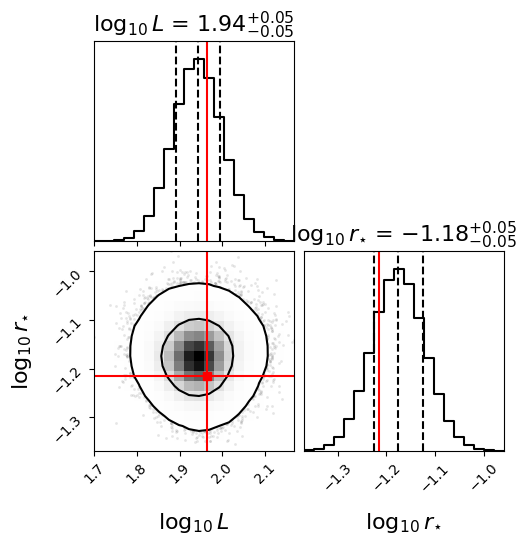

In [467]:
import corner

samples = np.array([posterior_dict_lp['logL'], posterior_dict_lp['logr_star']]).T

truths = (
    np.log10(len(pos)), truth_parameters['stellar_log_r_star']
)
labels = [r'$\log_{10} L$', r"$\log_{10} r_{\star}$"]

# Plot all chains
plot_args = dict(
    truth_color='red', truth_alpha=0.5, truth_kwargs={'linewidth': 2},
    label_kwargs={'fontsize': 16}, title_kwargs={'fontsize': 16},
    show_titles=True, levels=[0.68, 0.98], smooth=0.8, smooth1d=1.0, quantiles=[0.16, 0.5, 0.84],
    labels=labels, plot_datapoints=True,
)

figure = corner.corner(
    samples, truths=truths, **plot_args
)
plt.show(block=False)

## Jeans analysis

In [468]:
def log_plummer2d(r: jnp.ndarray, L: float, r_star: float) -> jnp.ndarray:
    """ Compute the log density of the 2D Plummer profile.
    Here, r is the projected radius instead of the 3D radius. Equation:
    ```
    log10 rho(r) = log10 L - 2 log10 r_star - 2 log10 (1 + r^2 / r_star^2) - log10 pi
    ```
    where:
        L: luminosity
        r_star: scale radius
    
    Parameters
    ----------
    r: jnp.ndarray
        The radius
    L: float
        The log luminosity
    r_star: float
        The scale radius
    
    Returns
    -------
    jnp.ndarray
        The log density    
    """
    x = r / r_star
    return jnp.log10(L) - 2 * jnp.log10(r_star) - 2 * jnp.log10(1 + x**2) - jnp.log10(jnp.pi)
    
def log_plummer3d(r: jnp.ndarray, L: float, r_star: float) -> jnp.ndarray:
    """ Compute the log density of the 3D Plummer profile.
    Equation:
    ```
    log10 rho(r) = log10 L - 3 log10 r_star - 5/2 log10 (1 + r^2 / r_star^2) - log10 4 pi / 3
    ```
    where:
        L: luminosity
        r_star: scale radius
    """
    x = r / r_star
    return (jnp.log10(L) - 3 * jnp.log10(r_star) - (5/2) * jnp.log10(1 + x**2)
            - jnp.log10(4 * jnp.pi / 3))

def log_gnfw(
    r: jnp.ndarray, rho_0: float, r_dm: float, gamma: float) -> jnp.ndarray:
    """ Compute the log density of the generalized NFW profile.
    Equation:
    ```
    log10 rho(r) = log10 rho_0 - gamma * log10(r / r_dm) - (3 - gamma) * log10(1 + r / r_dm)
    ```
    where:
        rho_0: central density
        r_dm: dark matter halo scale radius
        gamma: power law index
    """
    x = r / r_dm
    return jnp.log10(rho_0) - gamma * jnp.log10(x) - (3 - gamma) * jnp.log10(1 + x)

def cmass_gnfw(r: jnp.ndarray, rho_0: float, r_dm: float, gamma: float) -> jnp.ndarray:
    """ Compute the cumulative mass of the generalized NFW profile.
    """    
    density = jnp.float_power(10, log_gnfw(r, rho_0, r_dm, gamma))
    res = utils.jax_cumtrapz_init(y=density, x=r, initial=0)
    return res

def beta_om(r: jnp.ndarray, beta_0: float, r_a: float) -> jnp.ndarray:
    """ Compute the velocity anisotropy of the Osipkov-Merrit distribution function.
    Equation:
    ```
    beta(r) = beta_0 * (r / r_a)^2 / (1 + r / r_a)^2
    ```
    where:
        beta_0: central velocity anisotropy
        r_a: scale radius
    """
    x = r / r_a
    return beta_0 * x**2 / (1 + x)**2

In [469]:
# global data
r_min_factor = 0.5
r_max_factor = 2.0
dr = 0.01

# global parameters for liklihood
r_min = jnp.min(radius_proj) * r_min_factor
r_max = jnp.max(radius_proj) * r_max_factor
int_radius = jnp.arange(r_min, r_max, dr)
vel_var = vel_error**2

In [470]:
def calc_sigma2p_Sigma(R, r, sigma2_nu, beta):
    """ Calculate the projected Jeans integration:
    .. math::
    sigma2_p(R) Sigma(R) = 2 * int_R^\intfy (1 - beta * R^2 /r^2) (nu(r) sigma2(r) r) / sqrt(r^2 - R^2) dr

    where:
    - R is the projected radius
    - Sigma(R) is the 3D light profile

    Parameters
    ----------
    R: array of M float
        The 2D radius in kpc
    r: array of N float
        The 3D radius in kpc
    sigma2_nu: array of N float
        The 3D velocity dispersion
    beta: array of N float
        The velocity anisotropy

    Returns
    -------
    sigma2p_Sigma: array of M float
        The projected velocity dispersion
    """
    dr = r[1] - r[0]
    R = R[:, None]
    r = r[None, :]
    sigma2_nu = sigma2_nu[None, :]
    rminR2 = r**2 - R**2
    beta = beta[None, :]

    inte = (1 - beta * R**2 / r**2) * sigma2_nu * r
    inte = jnp.where(rminR2 > 0.,  inte / jnp.sqrt(jnp.abs(rminR2)), 0.)
    sigma2p_Sigma = 2 * jnp.trapz(inte, x=r, axis=1)
    return sigma2p_Sigma

In [472]:
# prior distribution
min_logrho_0, max_logrho_0 = 5., 8.
min_logr_dm, max_logr_dm = -2., 1.
min_gamma, max_gamma = -1., 2.
# min_logL, max_logL = np.percentile(samples[..., 0], [16, 84])
# min_logr_star, max_logr_star = np.percentile(samples[..., 1], [16, 84])
min_logr_a, max_logr_a = -2., 1.
# min_beta_0, max_beta_0 = -0.5, 0.5
min_v_mean, max_v_mean = -200, 200

def log_likelihood(
    logrho_0, logr_dm, gamma, logr_star, logL, logr_a, v_mean):
    """ The log likelihood given a set of DM parameters.
    For each star the log likelihood is defined as:
    .. math::
    logL = -0.5 * (v - v_mean)^2 / (sigma2_p + v_err^2) - 0.5 * log(2 pi  * (sigma2_p + verr^2))

    where:
    - v is the velocity of the star
    - v_mean is the mean velocity of all stars
    - v_err is the measurement error
    - sigma2_p is the velocity dispersion
    """
    r_a = jnp.float_power(10, logr_a)
    r_dm = jnp.float_power(10, logr_dm)
    r_star = jnp.float_power(10, logr_star)
    rho_0 = jnp.float_power(10, logrho_0)
    L = jnp.float_power(10, logL)
    beta_0 = 0.12881816386775002
    
    # First, we calculate the projected velocity dispersion profile
    # calculate the velocity ani Beta(r) and the anisotropy integral g(r)
    beta = beta_om(int_radius, beta_0, r_a)
    gint = utils.calc_gint(int_radius, beta)

    # Calculate the light porilf at each particle radius
    Sigma = jnp.float_power(10, log_plummer2d(radius_proj, L, r_star))

    # calculate the DM density profile at each integration radius
    nu = jnp.float_power(10, log_plummer3d(int_radius, L, r_star))

    # integrate the 3d Jeans velocity dispersion equation
    cmass = cmass_gnfw(int_radius, rho_0, r_dm, gamma)
    sigma2_nu = utils.calc_sigma2_nu(int_radius, cmass, nu, gint)

    # integrate the 2d velocity dispersion equation
    sigma2p_Sigma = calc_sigma2p_Sigma(radius_proj, int_radius, sigma2_nu, beta)
    sigma2p = sigma2p_Sigma / Sigma 
    sigma2p *= const.G.to_value(u.kpc**3 / u.Msun / u.s**2) * utils.kpc_to_km**2

    # calculate the log likelihood from the velocity dispersion
    # and the velocity measurement error
    var = sigma2p + vel_var
    logLL = -0.5 * (vel - v_mean)**2 / var
    logLL = logLL - 0.5 * jnp.log(2 * jnp.pi * var)
    logLL = jnp.sum(logLL)

    return logLL

In [473]:
# %%timeit
jax.jit(log_likelihood)(1., 1., 1., 1., 1., 1., 1.)

Array(-98693.5587452, dtype=float64)

In [537]:
def model():
    logrho_0 = numpyro.sample("logrho_0", dist.Uniform(min_logrho_0, max_logrho_0))
    logr_dm = numpyro.sample("logr_dm", dist.Uniform(min_logr_dm, max_logr_dm))
    gamma = numpyro.sample("gamma", dist.Uniform(min_gamma, max_gamma))
        
    logr_a = numpyro.sample("logr_a", dist.Uniform(min_logr_a, max_logr_a))
    v_mean = numpyro.sample("v_mean", dist.Uniform(min_v_mean, max_v_mean))

    loglike = log_likelihood(logrho_0, logr_dm, gamma, posterior_dict_lp['logr_star'].mean(), posterior_dict_lp['logL'].mean(), logr_a, v_mean)
        
    return numpyro.factor('log_like', loglike)

rng_key=jax.random.PRNGKey(1)

guide = autoguide.AutoIAFNormal(model)
optimizer = optim.optax_to_numpyro(optax.chain(optax.clip(1.), optax.adamw(3e-4)))

svi = SVI(model, guide, optimizer, Trace_ELBO(num_particles=8))
svi_results = svi.run(rng_key, 20_000)

100%|█| 20000/20000 [00:18<00:00, 1070.42it/s, init loss: 254135.1469, avg. loss


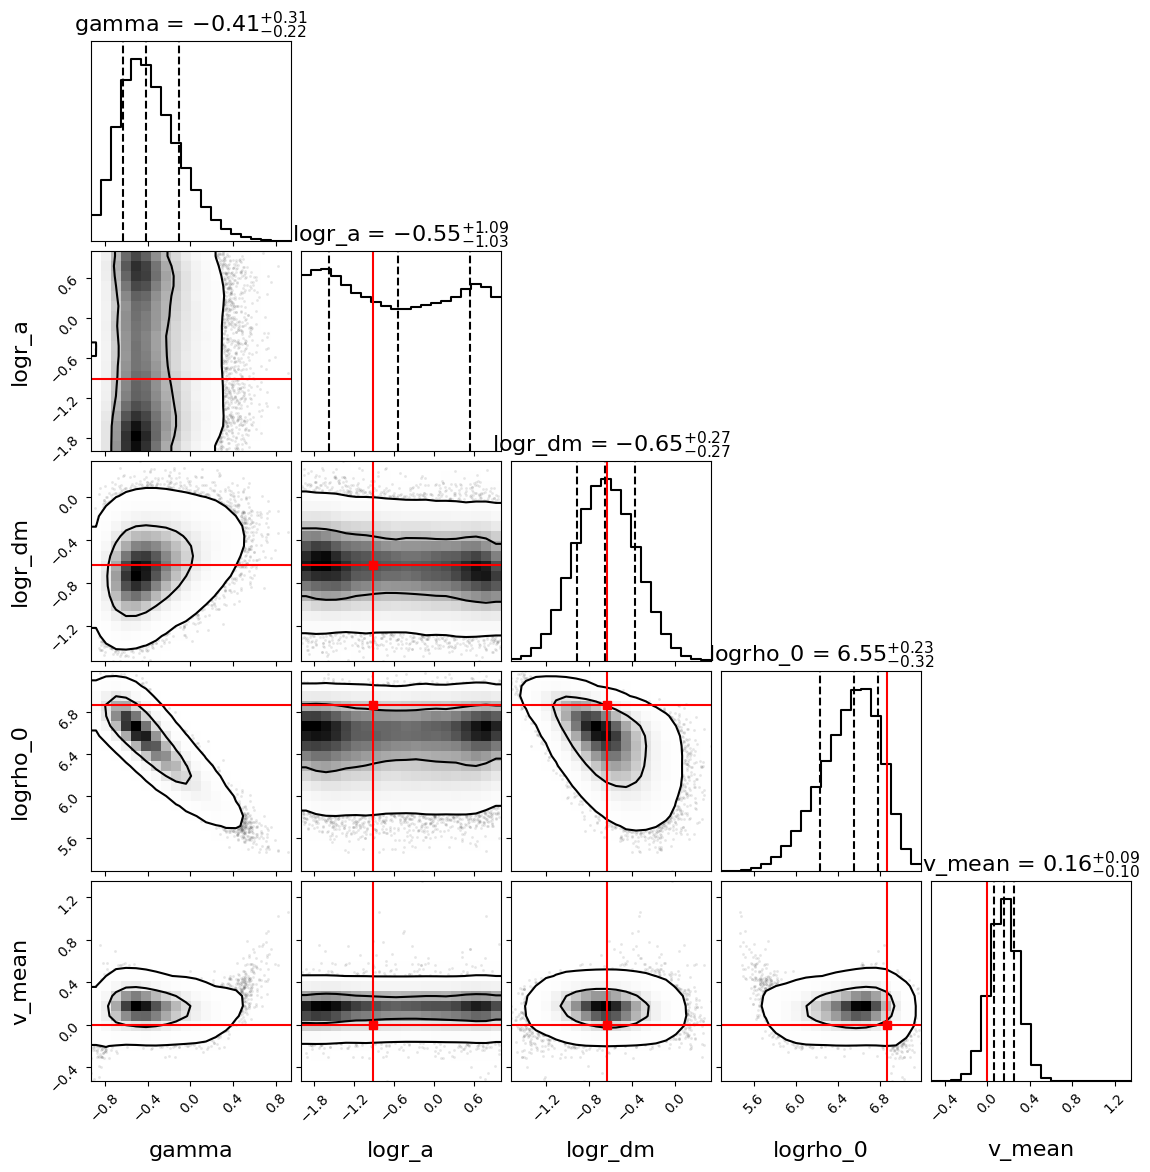

In [538]:
posterior_dict = get_posterior_samples(num_samples=50_000)

labels = ['gamma', 'logr_a', 'logr_dm', 'logrho_0', 'v_mean']
labels_truth = ['dm_gamma', 'df_log_r_a', 'dm_log_r_dm', 'dm_log_rho_0']
samples = np.array([posterior_dict[label] for label in labels]).T
truths = np.array([truth_parameters[label] for label in labels_truth] + [0.]).T
corner.corner(samples, truths=truths, **plot_args);

In [539]:
kernel = NUTS(model, max_tree_depth=4, dense_mass=False)
mcmc = MCMC(kernel, num_warmup=500, num_samples=20_000, num_chains=6, chain_method='vectorized')
mcmc.run(rng_key)

sample: 100%|████████████████████████████| 20500/20500 [02:46<00:00, 123.42it/s]


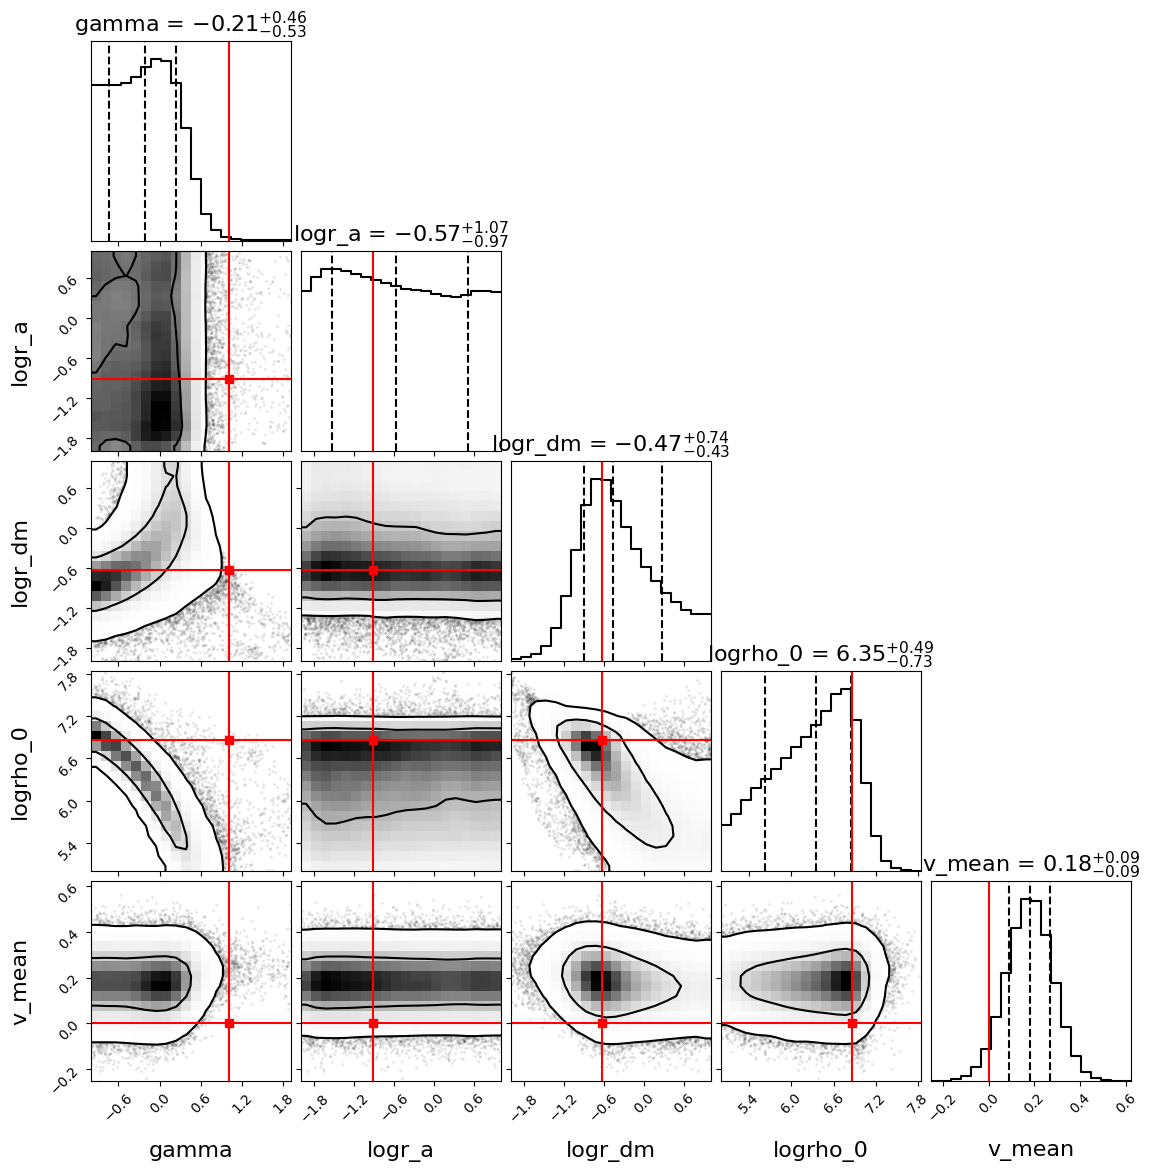

In [541]:
posterior_dict = mcmc.get_samples()

labels = ['gamma', 'logr_a', 'logr_dm', 'logrho_0', 'v_mean']
labels_truth = ['dm_gamma', 'df_log_r_a', 'dm_log_r_dm', 'dm_log_rho_0']
samples = np.array([posterior_dict[label] for label in labels]).T
truths = np.array([truth_parameters[label] for label in labels_truth] + [0.]).T
corner.corner(samples, truths=truths,  **plot_args);